In [1]:
import sys
utils = '/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/utils'
sys.path.insert(0, utils)

In [2]:
from pathlib import Path
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sql import connect
# from ml import models

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# import tensorflow as tf
import HydroErr as he

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Preparation

In [3]:
# Load dataset from the SQL database
def load_sql_dataset(query, connection, columns, chunksize = 1000):
    """Load dataset from the SQL database"""
    df = pd.read_sql(query, connection, columns=columns, parse_dates=['date'], chunksize=chunksize)
    return df


In [4]:
# Create a connection object to the MySQL database
conn = connect.Connect('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Methods/database_management/mysql_config.ini')
cursor = conn.conn.cursor()

Connecting to MySQL database...
Connection established.


In [5]:
# Reaches of interest to CRITFC
reaches_of_interest = ["Yakima_River_51","White_Salmon_River_11","Snake_River_186","Snake_River_161","Little_White_Salmon_River_5","Hood_River_3","Deschutes_River_54","Cowlitz_River_27","Columbia_River_255","Columbia_River_237","Columbia_River_235","Columbia_River_233","Columbia_River_232","Columbia_River_231","Columbia_River_229","Columbia_River_226","Columbia_River_223","Columbia_River_221","Columbia_River_203","Columbia_River_195","Columbia_River_193","Columbia_River_178","Columbia_River_174","Columbia_River_165","Columbia_River_160","Columbia_River_150","Columbia_River_143","Columbia_River_131","Columbia_River_121"]
# print(tuple(reaches_of_interest))

In [6]:
# data = load_sql_dataset(query = f"""
# SELECT
# 	ReachLandsatWaterTemp.date,
#     ReachLandsatWaterTemp.Value as watertemp,
#     ReachLandsatLandTemp.Value as landtemp,
#     ReachNDVI.Value as NDVI,
#     Reaches.ClimateClass
# FROM
# 	ReachLandsatWaterTemp
# INNER JOIN ReachLandsatLandTemp USING (date, ReachID)
# INNER JOIN ReachNDVI USING (date, ReachID)
# INNER JOIN Reaches USING (ReachID)
# WHERE Reaches.Name NOT IN {tuple(reaches_of_interest)} AND ReachLandsatWaterTemp.Value > 0
# ORDER BY RAND();
# """, connection = conn.engine, columns = ['date', 'watertemp', 'landtemp', 'NDVI', 'ClimateClass'])

query = f"""
SELECT 
    STR_TO_DATE(CONCAT(Year,
                    '-',
                    LPAD(Month, 2, '00'),
                    '-',
                    LPAD(DayOfMonth, 2, '00')),
            '%Y-%m-%d') AS Date,
    Month,
    DayOfMonth,
    ROUND(WaterTemp, 2) as WaterTemp,
    ROUND(LandTemp, 2) as LandTemp,
    ROUND(NDVI, 2) as NDVI,
    ClimateClass,
    --     ROUND(((watertemp - WaterTemperature) / WaterTemperature),
    --             2) AS PercentDeviation,
    --     ROUND((watertemp - WaterTemperature), 2) AS Deviation,
    Width,
    ReachID,
    ROUND(InsituTemp, 2) AS InsituTemp
FROM
    (SELECT 
        1 AS DayOfMonth,
            MONTH(ReachLandsatWaterTemp.date) AS Month,
            YEAR(ReachLandsatWaterTemp.date) AS Year,
            AVG(ReachLandsatWaterTemp.Value) AS WaterTemp,
            AVG(ReachLandsatLandTemp.Value) AS LandTemp,
            AVG(ReachNDVI.Value) AS NDVI,
            IFNULL(Reaches.WidthMean, 30) AS Width,
            Reaches.ClimateClass AS ClimateClass,
            ReachLandsatWaterTemp.ReachID AS ReachID
    FROM
        ReachLandsatWaterTemp
    INNER JOIN ReachLandsatLandTemp USING (date , ReachID)
    INNER JOIN ReachNDVI USING (date , ReachID)
    INNER JOIN Reaches USING (ReachID)
    WHERE
        ReachLandsatWaterTemp.Value > 0
    --    Reaches.Name NOT IN {tuple(reaches_of_interest)}
    --        AND ReachLandsatWaterTemp.Value > 0
    GROUP BY DayOfMonth , Month , Year , ClimateClass , ReachID , Width) AS T
    --         INNER JOIN
    --     ReachLandsatLTMSemiMonthly USING (DayOfMonth , Month , ReachID)
        LEFT JOIN
    (SELECT 
        1 AS DayOfMonth,
            MONTH(ReachInsituWaterTemp.date) AS Month,
            YEAR(ReachInsituWaterTemp.date) AS Year,
            AVG(ReachInsituWaterTemp.Value) AS InsituTemp,
            ReachInsituWaterTemp.ReachID AS ReachID
    FROM
        ReachInsituWaterTemp
    INNER JOIN Reaches USING (ReachID)
    WHERE
        ReachInsituWaterTemp.Value > 0
    GROUP BY DayOfMonth , Month , Year , ReachID) AS I USING (DayOfMonth , Month , Year , ReachID)
ORDER BY RAND();
""" 
# print(query)

df = conn.query_with_fetchmany(query, chunksize=100)

In [7]:
# df = pd.concat([chunk for chunk in data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear

In [8]:
df[df["InsituTemp"].isnull()].head()

,Date,Month,DayOfMonth,WaterTemp,LandTemp,NDVI,ClimateClass,Width,ReachID,InsituTemp,DayOfYear
0,2019-04-01,4,1,2.03,4.88,0.86,29,30.0,58,NaN,91
1,2015-10-01,10,1,18.39,19.88,0.68,9,30.0,682,NaN,274
2,2022-05-01,5,1,10.44,18.13,0.40,9,1094.0,336,NaN,121
3,2023-09-01,9,1,17.51,20.33,0.72,26,1397.0,445,NaN,244
4,2023-02-01,2,1,6.12,9.94,0.29,5,30.0,477,NaN,32


[Text(0.5, 0, 'Landsat Land Temperature (C$^\\circ$)'),
 Text(0, 0.5, 'Landsat Water Temperature (C$^\\circ$)')]

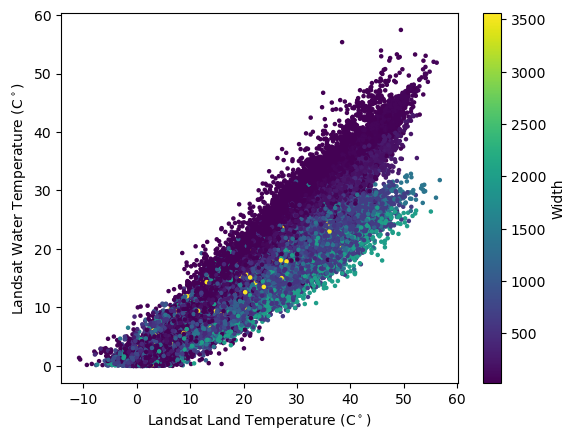

In [11]:
# plot a scatter of the land temperature and water temperature
ax = df.plot.scatter(x='LandTemp', y='WaterTemp', c='Width', colormap='viridis', marker='.')
ax.set(xlabel='Landsat Land Temperature (C$^\circ$)', ylabel='Landsat Water Temperature (C$^\circ$)')

In [12]:
df_with_insitu = df[df["InsituTemp"].notnull()].copy()
df_with_insitu["deviation"] = df_with_insitu["WaterTemp"] - df_with_insitu["InsituTemp"]

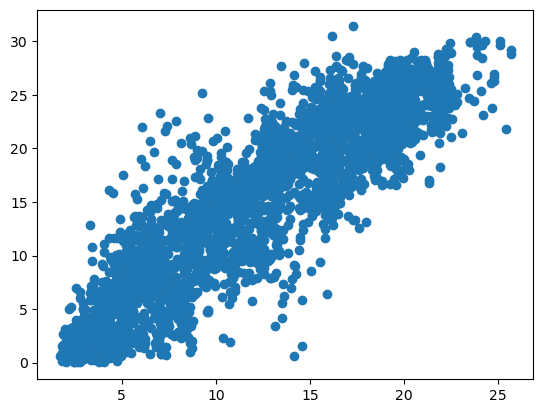

In [13]:
fig, ax = plt.subplots()
ax.scatter(df_with_insitu[df_with_insitu["Width"]>250]["InsituTemp"], df_with_insitu[df_with_insitu["Width"]>250]["WaterTemp"])



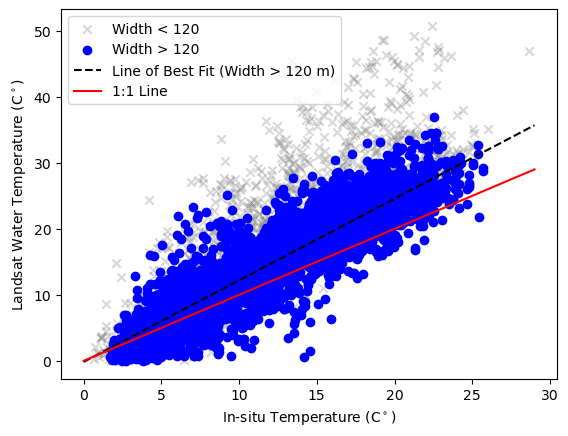

In [14]:
fig, ax = plt.subplots()
ax.scatter(
    df_with_insitu[df_with_insitu["Width"] < 120]["InsituTemp"],
    df_with_insitu[df_with_insitu["Width"] < 120]["WaterTemp"],
    color="grey",
    marker="x",
    alpha=0.3,
    label="Width < 120",
)
ax.scatter(
    df_with_insitu[df_with_insitu["Width"] > 120]["InsituTemp"],
    df_with_insitu[df_with_insitu["Width"] > 120]["WaterTemp"],
    color="blue",
    label="Width > 120",
)
# add a line of best fit to width > 120
x = df_with_insitu[df_with_insitu["Width"] > 120]["InsituTemp"]
y = df_with_insitu[df_with_insitu["Width"] > 120]["WaterTemp"]
m, b = np.polyfit(list(x), list(y), 1)
ax.plot(np.arange(0,30), m * np.arange(0,30) + b, color="black", linestyle="--", label="Line of Best Fit (Width > 120 m)")
# add 1:1 line
ax.plot(np.arange(0,30), np.arange(0,30), color="red", linestyle="-", label="1:1 Line")



ax.set(xlabel="In-situ Temperature (C$^\circ$)", ylabel="Landsat Water Temperature (C$^\circ$)")
ax.legend()

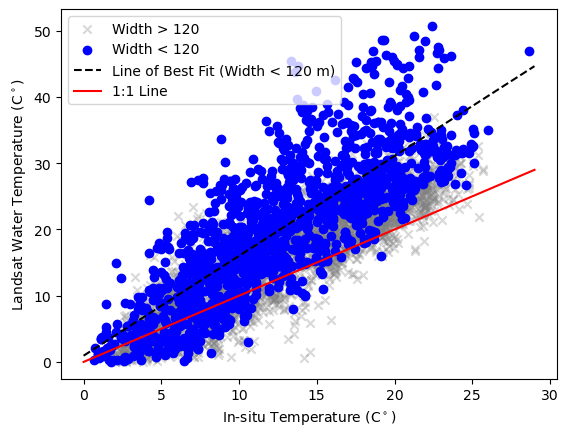

In [15]:
fig, ax = plt.subplots()
ax.scatter(
    df_with_insitu[df_with_insitu["Width"] > 120]["InsituTemp"],
    df_with_insitu[df_with_insitu["Width"] > 120]["WaterTemp"],
    color="grey",
    alpha=0.3,
    marker="x",
    label="Width > 120",
)

ax.scatter(
    df_with_insitu[df_with_insitu["Width"] < 120]["InsituTemp"],
    df_with_insitu[df_with_insitu["Width"] < 120]["WaterTemp"],
    color="blue",
    label="Width < 120",
)
# add a line of best fit to width > 120
x = df_with_insitu[df_with_insitu["Width"] < 120]["InsituTemp"]
y = df_with_insitu[df_with_insitu["Width"] < 120]["WaterTemp"]
m, b = np.polyfit(list(x), list(y), 1)
ax.plot(np.arange(0,30), m * np.arange(0,30) + b, color="black", linestyle="--", label="Line of Best Fit (Width < 120 m)")
# add 1:1 line
ax.plot(np.arange(0,30), np.arange(0,30), color="red", linestyle="-", label="1:1 Line")



ax.set(xlabel="In-situ Temperature (C$^\circ$)", ylabel="Landsat Water Temperature (C$^\circ$)")
ax.legend()

In [16]:
mean_deviations = []
variance_deviations = []
best_fit_gradient = []
mean_widths = []

In [17]:
for i in range(0, 1440, 120):
    # print(i, i+120)
    mean_widths.append(df_with_insitu[(df_with_insitu["Width"] >= i) & (df_with_insitu["Width"] < i + 120)]["Width"].mean())
    mean_deviations.append(df_with_insitu[(df_with_insitu["Width"] >= i) & (df_with_insitu["Width"] < i + 120)]["deviation"].mean())
    variance_deviations.append(df_with_insitu[(df_with_insitu["Width"] >= i) & (df_with_insitu["Width"] < i + 120)]["deviation"].var())
    best_fit_gradient.append(np.polyfit(list(df_with_insitu[(df_with_insitu["Width"] >= i) & (df_with_insitu["Width"] < i + 120)]["InsituTemp"]), list(df_with_insitu[(df_with_insitu["Width"] >= i) & (df_with_insitu["Width"] < i + 120)]["WaterTemp"]), 1)[0])

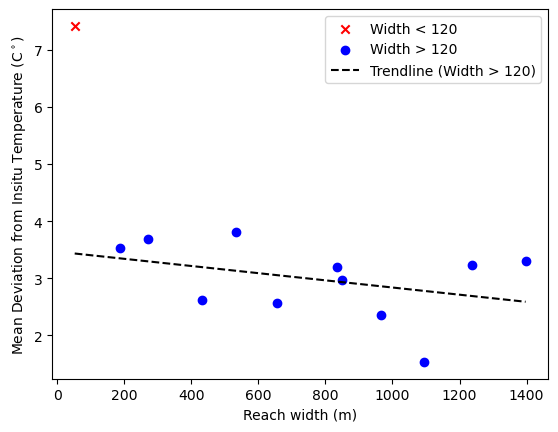

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# x values - years
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
# y values - 1 USD in INR
y = [46.67, 53.44, 56.57, 62.33, 62.97, 66.46, 67.79, 70.09, 70.39, 76.38]
# plot x and y on scatter plot
plt.scatter(mean_widths[0], mean_deviations[0], color="red", label='Width < 120', marker='x')
plt.scatter(mean_widths[1:], mean_deviations[1:], color="blue",label='Width > 120')
plt.xlabel('Reach width (m)')
plt.ylabel('Mean Deviation from Insitu Temperature (C$^\circ$)')
# get the trendline coefficients
z = np.polyfit(mean_widths[1:], mean_deviations[1:], 1)
# get the polynomial to generate the trendline
p = np.poly1d(z)
# add trendline to the plot
plt.plot(mean_widths, p(mean_widths), "k--", label='Trendline (Width > 120)')
plt.legend()

[Text(0.5, 0, 'Mean Deviation from Insitu Temperature (C$^\\circ$)'),
 Text(0, 0.5, 'Density')]

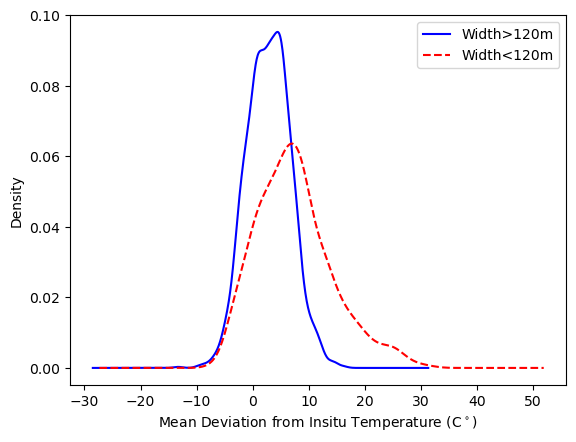

In [19]:
fig, ax = plt.subplots()
df_with_insitu[df_with_insitu["Width"]>120]["deviation"].plot(kind="kde", ax=ax, label="Width>120m", color="blue", linestyle="-")
df_with_insitu[df_with_insitu["Width"]<120]["deviation"].plot(kind="kde", ax=ax, label="Width<120m", color="red", linestyle="--")
# df_with_insitu["deviation"].plot(kind="kde", ax=ax, label="All")
ax.legend()
ax.set(xlabel='Mean Deviation from Insitu Temperature (C$^\circ$)', ylabel='Density')
# plt.show()

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_2514/3490170029.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 30], [0, 30], 'k-', color = 'r')


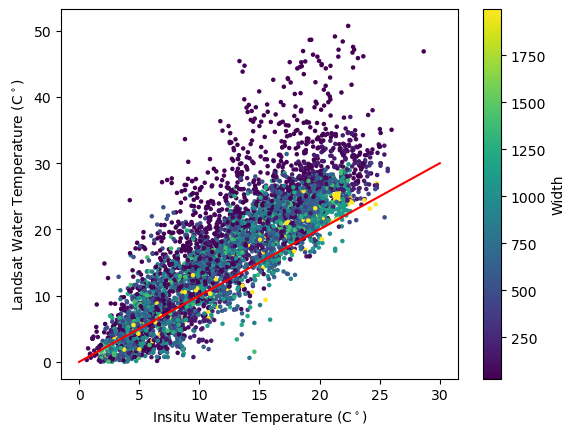

In [20]:
# plot a scatter of the land temperature and water temperature
ax = df.plot.scatter(x='InsituTemp', y='WaterTemp', c='Width', colormap='viridis', marker='.')
ax.set(xlabel='Insitu Water Temperature (C$^\circ$)', ylabel='Landsat Water Temperature (C$^\circ$)')
# add 1:1 line
ax.plot([0, 30], [0, 30], 'k-', color = 'r')


In [21]:
import numpy as np
from scipy import stats

In [24]:
print("var > 120 m: " + str(df_with_insitu[df_with_insitu["Width"] > 120]["deviation"].var()) + "\n var < 120 m: " + str(df_with_insitu[df_with_insitu["Width"] < 120]["deviation"].var()))

var > 120 m: 15.0601040266993
 var < 120 m: 46.26158942736519


In [25]:
stats.ttest_ind(
    list(df_with_insitu[df_with_insitu["Width"] > 120]["deviation"].to_numpy()),
    list(df_with_insitu[df_with_insitu["Width"] < 120]["deviation"].to_numpy()),
    alternative="less",
    equal_var=False,
)

Ttest_indResult(statistic=-23.689770017074153, pvalue=1.6159936908859739e-108)

In [26]:
df_with_insitu['deviation'] = pd.to_numeric(df_with_insitu['deviation'])

In [27]:
df_with_insitu[df_with_insitu["Width"] >120].describe()

,Month,DayOfMonth,WaterTemp,LandTemp,NDVI,ClimateClass,Width,ReachID,DayOfYear,deviation
count,3358.000000,3358.0,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000
mean,6.603633,1.0,15.507222,22.807936,0.382856,10.733472,774.421828,705.208755,170.670935,2.834419
std,2.959031,0.0,8.115291,12.065064,0.141003,7.269370,415.937096,442.987328,90.197607,3.880735
min,1.000000,1.0,0.010000,-4.460000,0.020000,5.000000,155.000000,203.000000,1.000000,-13.560000
25%,4.000000,1.0,8.562500,13.350000,0.280000,7.000000,498.000000,260.000000,91.000000,0.170000
50%,7.000000,1.0,16.195000,23.595000,0.350000,7.000000,655.000000,634.000000,182.000000,2.870000
75%,9.000000,1.0,22.400000,32.405000,0.470000,9.000000,1094.000000,1175.000000,244.000000,5.490000
max,12.000000,1.0,36.990000,49.900000,0.930000,27.000000,1996.000000,1289.000000,336.000000,16.340000


In [28]:
df_with_insitu[df_with_insitu["Width"] <120].describe()

,Month,DayOfMonth,WaterTemp,LandTemp,NDVI,ClimateClass,Width,ReachID,DayOfYear,deviation
count,1406.000000,1406.0,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000
mean,6.670697,1.0,20.177141,23.083748,0.473343,7.952347,52.480797,722.065434,172.719772,7.415057
std,2.988297,0.0,10.500176,11.280269,0.119974,2.822861,20.893783,431.326868,91.073337,6.801587
min,1.000000,1.0,0.030000,-0.210000,0.200000,5.000000,30.000000,12.000000,1.000000,-7.530000
25%,4.000000,1.0,12.242500,14.392500,0.380000,7.000000,30.000000,570.000000,91.000000,2.490000
50%,7.000000,1.0,20.325000,23.540000,0.460000,7.000000,50.000000,789.000000,182.000000,6.740000
75%,9.000000,1.0,27.390000,31.597500,0.570000,9.000000,72.000000,1042.000000,244.000000,11.142500
max,12.000000,1.0,50.730000,49.720000,0.820000,27.000000,97.000000,1343.000000,336.000000,32.080000
